# Anomaly Detection

Anomaly detection is the task of identifying unusual patterns in data, usually using machine learning algorithms. ML-based anomaly detection automates the identification of abnormal behavior, enhancing security, efficiency, and reliability in various domains.

## Test on a well known dataset (CreditCard)

River provides various datasets to test the methods they built, one of which is CreditCard, a dataset containing many transaction occurring in a bank, and some of them are frauds. The library creators describe the dataset in this way:

    The datasets contains transactions made by credit cards in September 2013 by european
    cardholders. This dataset presents transactions that occurred in two days, where we have 492
    frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class
    (frauds) account for 0.172% of all transactions.
    It contains only numerical input variables which are the result of a PCA transformation.
    Unfortunately, due to confidentiality issues, we cannot provide the original features and more
    background information about the data. Features V1, V2, ... V28 are the principal components
    obtained with PCA, the only features which have not been transformed with PCA are 'Time' and
    'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first
    transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be
    used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and
    it takes value 1 in case of fraud and 0 otherwise.

**Samples:** 284807 (only 5000 were taken for the computation)

**Classes:** 0(normal), 1(abnormal)


In [1]:
from pipeline import anomaly_detection
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import random
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from deep_river.anomaly import Autoencoder, ProbabilityWeightedAutoencoder, RollingAutoencoder
from ad_model_training import train_model,build_model,test_model, test_sample
from river.compose import Pipeline
from river.preprocessing import MinMaxScaler
from torch import nn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch


c:\Users\loren\PycharmProjects\AnomalousSoundDetection\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\loren\PycharmProjects\AnomalousSoundDetection\venv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\loren\PycharmProjects\AnomalousSoundDetection\venv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In river repository there are a couple of examples on how to implement a simple anomaly detection pipeline with CreditCard dataset. However, not all the models of the library have their own example, and models from Deep River library have no example at all. For this reason, a test on each model of the two libraries has been performed in order to see if they are able to detect anomalies in simple situations like this one. To assess the performance rocauc was used (like in the river example).

In [2]:
# HST
model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.HalfSpaceTrees(seed=42)
)
auc = metrics.ROCAUC()
random.seed(42)
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x, y)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("HST Score: " + str(roc))

# SVM
model = anomaly.QuantileThresholder(
    anomaly.OneClassSVM(nu=0.2),
    q=0.995
)
auc = metrics.ROCAUC()
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("SVM Score: " + str(roc))


class MyAutoEncoder(nn.Module):
    def __init__(self, n_features, latent_dim=3):
        super(MyAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(n_features, latent_dim)
        self.non_linear = nn.LeakyReLU()
        self.linear2 = nn.Linear(latent_dim, n_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_X):
        input_X = self.linear1(input_X)
        input_X = self.non_linear(input_X)
        input_X = self.linear2(input_X)
        return self.sigmoid(input_X)


ae = Autoencoder(module=MyAutoEncoder, lr=0.005)
scaler = MinMaxScaler()
model = Pipeline(scaler, ae)
auc = metrics.ROCAUC(n_thresholds=50)
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x=x)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("AE Score: " + str(roc))

wae = ProbabilityWeightedAutoencoder(module=MyAutoEncoder, lr=0.005)
model = Pipeline(scaler, wae)
auc = metrics.ROCAUC(n_thresholds=50)
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x=x)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("WAE Score: " + str(roc))


rae = RollingAutoencoder(module=MyAutoEncoder, lr=0.005)
model = Pipeline(scaler, rae)
auc = metrics.ROCAUC(n_thresholds=50)
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x=x)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("RAE Score: " + str(roc))


model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.ILOF()
)
auc = metrics.ROCAUC()
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x, y)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("ILOF Score: " + str(roc))


model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.KitNet()
)
auc = metrics.ROCAUC()
scores, labels = [], []
for x, y in datasets.CreditCard().take(5000):
    score = model.score_one(x)
    model = model.learn_one(x, y)
    auc = auc.update(y, score)
    scores.append(score)
    labels.append(y)
roc = roc_auc_score(labels, scores)
print("Kitnet Score: " + str(roc))


clf = anomaly.RobustRandomCutForest(num_trees=10, tree_size=25)
from tqdm import tqdm
scores, labels = [], []
auc = metrics.ROCAUC()
for x, y in tqdm(datasets.CreditCard().take(5000)):
    score = clf.score_one(x)
    clf.learn_one(x)
    scores.append(score)
    labels.append(y)
    auc = auc.update(y, score)
roc = roc_auc_score(labels, scores)
print("RRCF Score: " + str(roc))

HST Score: 0.7861383496764726
SVM Score: 0.6653658861983857
AE Score: 0.83436728703889
WAE Score: 0.9593756253752251
RAE Score: 0.9050096724701487
ILOF Score: 0.9641118004135816
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
The Feature-Mapper found a mapping: 30 features to 14 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
Kitnet Score: 0.9732506170368889


5000it [00:34, 145.74it/s]

RRCF Score: 0.8313321326129011


All the models have high rocauc scores, usually above 0.8. This is sign that the models work well for this purpose.

## Test on Edge Impulse Dataset

This dataset is a sound dataset for malfunctioning industrial machine investigation and inspection (MIMII dataset). It contains the sounds generated from four types of industrial machines, i.e. valves, pumps, fans, and slide rails. Each type of machine includes seven individual product models, and the data for each model contains normal sounds (from 5000 seconds to 10000 seconds) and anomalous sounds (about 1000 seconds). To resemble a real-life scenario, various anomalous sounds were recorded (e.g., contamination, leakage, rotating unbalance, and rail damage). Also, the background noise recorded in multiple real factories was mixed with the machine sounds. The sounds were recorded by eight-channel microphone array with 16 kHz sampling rate and 16 bit per sample. 

**Samples:** 420

**Classes:** 0(normal), 1(abnormal)

### Plot the spectogram of a normal and an abnormal sample

Since we will use spectogram as one of the preprocessing methods to extract features from an audio sample, it is interesting to understand if it is possible to detect an anomaly "by eye", simply looking at the different spectogram plots of a normal sample and an abnormal one. For this reason the following method plots the spectogram of two wav audios, so we can directly compare the representations.

In [3]:
%matplotlib inline

def plot_spectogram(wav_path1, wav_path2):
    Fs1, aud1 = wavfile.read(wav_path1)
    Fs2, aud2 = wavfile.read(wav_path2)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the spectrogram for the first audio file
    powerSpectrum1, frequenciesFound1, time1, imageAxis1 = ax1.specgram(aud1, Fs=Fs1)
    ax1.set_title('Spectrogram 1 (normal)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency')

    # Plot the spectrogram for the second audio file
    powerSpectrum2, frequenciesFound2, time2, imageAxis2 = ax2.specgram(aud2, Fs=Fs2)
    ax2.set_title('Spectrogram 2 (abnormal)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Frequency')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

C:\Users\loren\AppData\Local\Temp\ipykernel_17624\1058484754.py:4: WavFileWarning: Reached EOF prematurely; finished at 320044 bytes, expected 320052 bytes from header.
  Fs1, aud1 = wavfile.read(wav_path1)
C:\Users\loren\AppData\Local\Temp\ipykernel_17624\1058484754.py:5: WavFileWarning: Reached EOF prematurely; finished at 320044 bytes, expected 320052 bytes from header.
  Fs2, aud2 = wavfile.read(wav_path2)


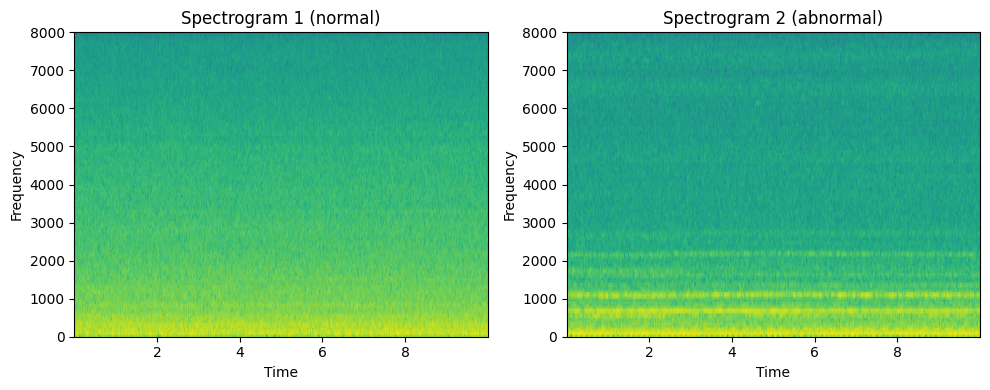

In [11]:
plot_spectogram("examples-to-show\edgeimpulse_normal.wav", "examples-to-show\edgeimpulse_abnormal.wav")

There is a notable difference between the samples: the normal one is basically a simple shade from a lighter part below to a darker one on the top; in the abnormal, instead, there are many notable light lines in the plot at difference frequency levels. 

If simply plotting the samples it is possible to detect anomalies, the models should be able to detect such differences too.

## Pipeline explanation

In the following part of the notebook, you will frequently find calls to a method like in this example:

    anomaly_detection(preprocess_method='spectrogram', model_name='svm', transfer_learning='dense',
                    train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

anomaly_detection is a method present in a different package of this repository, which performs the complete pipeline of anomaly detection. For a more detailed explanation it is possible to check the package itself, but to make it short: 
1. The pipeline is split in training and testing phase. In the former the model will learn how to classify different samples based on the true label such sample has, in the latter the model will score new unseen samples based on what it has learnt.
2. Performances are evaluated using rocauc score: in particular the most important evaluation is the testing score, as it compares the results of the models on unseen samples to the true labels of such samples.
3. Each sample to be studied is split in 9 subsamples of 2 seconds each
4. Through a preprocessing method it is possible to elaborate the .wav sound and obtain numerical features. The preprocessing methods that can be used are 'spectogram' and 'mfe'
5. A pretrained neural network is loaded (through transfer learning) and used to perform feature extraction, in order to reduce dimensionality and make the pipeline less time consuming. It is possible to decide which layer to maintain from the network and which to discard, basically deciding how many features to extract. The layers that can be chosen are flatten (which reduces the features number to 800) and dense (which reduces the features number to 20)
6. A model among the ones presented above is loaded and trained on the training set, then it's performances are evaluated based on the tesing set.

### Spectrogram preprocessing and feature extraction to dense layer (20 features)

In [5]:
anomaly_detection(preprocess_method='spectrogram', model_name='hst', transfer_learning='dense', train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='svm', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='ae', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [04:34<00:00,  1.25it/s]


TRAINING: hst rocauc score using dense: 0.18342138222636573


100%|██████████| 84/84 [01:12<00:00,  1.16it/s]


TESTING: hst rocauc score using dense: 0.9626771833561958


100%|██████████| 343/343 [05:19<00:00,  1.07it/s]


TRAINING: svm rocauc score using dense: 0.5263157894736843


100%|██████████| 84/84 [01:24<00:00,  1.01s/it]


TESTING: svm rocauc score using dense: 0.5


100%|██████████| 343/343 [06:13<00:00,  1.09s/it]


TRAINING: ae rocauc score using dense: 0.9552975299224982


100%|██████████| 84/84 [01:37<00:00,  1.16s/it]

TESTING: ae rocauc score using dense: 0.8356267146776407


In [3]:
anomaly_detection(preprocess_method='spectrogram', model_name='wae', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='rae', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='ilof', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [02:40<00:00,  2.14it/s]


TRAINING: wae rocauc score using dense: 0.8813623565085553


100%|██████████| 84/84 [00:40<00:00,  2.06it/s]


TESTING: wae rocauc score using dense: 0.8144933127572016


100%|██████████| 343/343 [02:54<00:00,  1.97it/s]


TRAINING: rae rocauc score using dense: 0.9793668954996186


100%|██████████| 84/84 [00:44<00:00,  1.89it/s]


TESTING: rae rocauc score using dense: 0.8355838477366254


100%|██████████| 343/343 [03:37<00:00,  1.58it/s]


TRAINING: ilof rocauc score using dense: 0.5088948215950504


100%|██████████| 84/84 [00:59<00:00,  1.42it/s]

TESTING: ilof rocauc score using dense: 0.45446816415180613


In [4]:
anomaly_detection(preprocess_method='spectrogram', model_name='kitnet', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='rrcf', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

  0%|          | 0/343 [00:00<?, ?it/s]

Feature-Mapper: train-mode, Anomaly-Detector: off-mode


  3%|▎         | 11/343 [00:07<03:23,  1.63it/s]

The Feature-Mapper found a mapping: 20 features to 11 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode


100%|██████████| 343/343 [03:37<00:00,  1.57it/s]


TRAINING: kitnet rocauc score using dense: 0.626669868444595


100%|██████████| 84/84 [00:55<00:00,  1.51it/s]


TESTING: kitnet rocauc score using dense: 0.9926983310470965


100%|██████████| 343/343 [04:18<00:00,  1.33it/s]


TRAINING: rrcf rocauc score using dense: 0.5358766279628218


100%|██████████| 84/84 [01:05<00:00,  1.28it/s]

TESTING: rrcf rocauc score using dense: 0.9168167009602194


**Compact results:**

    hst: 0.9626771833561958

    svm: 0.5

    ae: 0.8356267146776407

    wae: 0.8144933127572016

    rae: 0.8355838477366254

    ilof: 0.45446816415180613

    kitnet: 0.9926983310470965

    rrcf: 0.9168167009602194

Again the results are promising for most of the models.

### Spectrogram preprocessing and feature extraction to flatten layer (800 features)

In [2]:
anomaly_detection(preprocess_method='spectrogram', model_name='hst', transfer_learning='flatten', train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='svm', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='ae', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [02:59<00:00,  1.91it/s]


TRAINING: hst rocauc score using flatten: 0.10335551035398481


100%|██████████| 84/84 [00:43<00:00,  1.91it/s]


TESTING: hst rocauc score using flatten: 0.2540259202103338


100%|██████████| 343/343 [03:09<00:00,  1.81it/s]


TRAINING: svm rocauc score using flatten: 0.5642024747859987


100%|██████████| 84/84 [00:47<00:00,  1.78it/s]


TESTING: svm rocauc score using flatten: 0.5


100%|██████████| 343/343 [05:05<00:00,  1.12it/s]


TRAINING: ae rocauc score using flatten: 0.9952100460491002


100%|██████████| 84/84 [00:56<00:00,  1.49it/s]

TESTING: ae rocauc score using flatten: 0.9982424554183814


In [2]:
anomaly_detection(preprocess_method='spectrogram', model_name='wae', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='rae', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

anomaly_detection(preprocess_method='spectrogram', model_name='ilof', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [03:49<00:00,  1.49it/s]


TRAINING: wae rocauc score using flatten: 0.9950339482630355


100%|██████████| 84/84 [00:42<00:00,  1.95it/s]


TESTING: wae rocauc score using flatten: 0.998235310928212


100%|██████████| 343/343 [03:10<00:00,  1.80it/s]


TRAINING: rae rocauc score using flatten: 0.9902976711774067


100%|██████████| 84/84 [00:47<00:00,  1.77it/s]


TESTING: rae rocauc score using flatten: 0.9982424554183814


100%|██████████| 343/343 [04:00<00:00,  1.43it/s]


TRAINING: ilof rocauc score using flatten: 0.8250242487593111


100%|██████████| 84/84 [01:05<00:00,  1.28it/s]

TESTING: ilof rocauc score using flatten: 0.6811128257887518


In [3]:
anomaly_detection(preprocess_method='spectrogram', model_name='kitnet', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='spectrogram', model_name='rrcf', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

  0%|          | 0/343 [00:00<?, ?it/s]

Feature-Mapper: train-mode, Anomaly-Detector: off-mode


  3%|▎         | 11/343 [00:07<03:44,  1.48it/s]

The Feature-Mapper found a mapping: 800 features to 349 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode


100%|██████████| 343/343 [06:02<00:00,  1.06s/it]


TRAINING: kitnet rocauc score using flatten: 0.7726092606718084


100%|██████████| 84/84 [01:11<00:00,  1.18it/s]


TESTING: kitnet rocauc score using flatten: 0.9634130658436213


100%|██████████| 343/343 [05:04<00:00,  1.13it/s]


TRAINING: rrcf rocauc score using flatten: 0.6173453965025285


100%|██████████| 84/84 [01:07<00:00,  1.25it/s]

TESTING: rrcf rocauc score using flatten: 0.4947773776863283


**Compact results:**

    hst: 0.2540259202103338

    svm: 0.5

    ae: 0.9982424554183814

    wae: 0.998235310928212

    rae: 0.9982424554183814

    ilof: 0.6811128257887518

    kitnet: 0.9634130658436213
    
    rrcf: 0.4947773776863283

The results are slightly better than those of the last run. It is reasonable since now the number of features is 800 instead of 20, although the computational time is much more.

### MFE preprocessing and feature extraction to dense layer (20 features)

In [12]:
anomaly_detection(preprocess_method='mfe', model_name='hst', transfer_learning='dense', train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='svm', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='ae', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [03:19<00:00,  1.72it/s]


TRAINING: hst rocauc score using dense: 0.5


100%|██████████| 84/84 [00:47<00:00,  1.75it/s]


TESTING: hst rocauc score using dense: 0.5


100%|██████████| 343/343 [03:20<00:00,  1.71it/s]


TRAINING: svm rocauc score using dense: 0.4453746080176286


100%|██████████| 84/84 [00:46<00:00,  1.81it/s]


TESTING: svm rocauc score using dense: 0.5


100%|██████████| 343/343 [04:58<00:00,  1.15it/s]


TRAINING: ae rocauc score using dense: 1.0


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]

TESTING: ae rocauc score using dense: 0.5


In [2]:
anomaly_detection(preprocess_method='mfe', model_name='wae', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='rae', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [04:07<00:00,  1.38it/s]


TRAINING: wae rocauc score using dense: 1.0


100%|██████████| 84/84 [00:44<00:00,  1.90it/s]


TESTING: wae rocauc score using dense: 0.5


100%|██████████| 343/343 [03:19<00:00,  1.72it/s]


TRAINING: rae rocauc score using dense: 0.9903381642512077


100%|██████████| 84/84 [00:48<00:00,  1.73it/s]

TESTING: rae rocauc score using dense: 0.5


In [3]:
anomaly_detection(preprocess_method='mfe', model_name='kitnet', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='rrcf', transfer_learning='dense',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

  0%|          | 0/343 [00:00<?, ?it/s]

Feature-Mapper: train-mode, Anomaly-Detector: off-mode


  3%|▎         | 11/343 [00:07<03:52,  1.43it/s]

The Feature-Mapper found a mapping: 1536 features to 1527 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode


100%|██████████| 343/343 [11:24<00:00,  2.00s/it]


TRAINING: kitnet rocauc score using dense: 0.9014492753623189


100%|██████████| 84/84 [01:24<00:00,  1.01s/it]


TESTING: kitnet rocauc score using dense: 0.5


100%|██████████| 343/343 [03:52<00:00,  1.47it/s]


TRAINING: rrcf rocauc score using dense: 0.5


100%|██████████| 84/84 [01:01<00:00,  1.37it/s]

TESTING: rrcf rocauc score using dense: 0.5


**Compact results:**

    hst: 0.5

    svm: 0.5

    ae: 0.5

    wae: 0.5

    rae: 0.5

    kitnet: 0.5
    
    rrcf: 0.5

Now the results are way worse with a rocauc score of 0.5. This suggest that mfe is not able to effectively extract meaningful features.

### MFE preprocessing and feature extraction to flatten layer (800 features)

In [2]:
anomaly_detection(preprocess_method='mfe', model_name='hst', transfer_learning='flatten', train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='svm', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='ae', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [03:00<00:00,  1.90it/s]


TRAINING: hst rocauc score using flatten: 0.5


100%|██████████| 84/84 [00:43<00:00,  1.93it/s]


TESTING: hst rocauc score using flatten: 0.5


100%|██████████| 343/343 [03:13<00:00,  1.78it/s]


TRAINING: svm rocauc score using flatten: 0.4453746080176286


100%|██████████| 84/84 [00:46<00:00,  1.79it/s]


TESTING: svm rocauc score using flatten: 0.5


100%|██████████| 343/343 [04:52<00:00,  1.17it/s]


TRAINING: ae rocauc score using flatten: 1.0


100%|██████████| 84/84 [00:56<00:00,  1.48it/s]

TESTING: ae rocauc score using flatten: 0.5


In [2]:
anomaly_detection(preprocess_method='mfe', model_name='wae', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='rae', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')
anomaly_detection(preprocess_method='mfe', model_name='rrcf', transfer_learning='flatten',
                  train_directory='edge_impulse/training', test_directory='edge_impulse/testing')

100%|██████████| 343/343 [04:02<00:00,  1.41it/s]


TRAINING: wae rocauc score using flatten: 1.0


100%|██████████| 84/84 [00:45<00:00,  1.86it/s]


TESTING: wae rocauc score using flatten: 0.5


100%|██████████| 343/343 [03:20<00:00,  1.71it/s]


TRAINING: rae rocauc score using flatten: 0.9903381642512077


100%|██████████| 84/84 [00:49<00:00,  1.70it/s]


TESTING: rae rocauc score using flatten: 0.5


100%|██████████| 343/343 [03:23<00:00,  1.68it/s]


TRAINING: rrcf rocauc score using flatten: 0.5


100%|██████████| 84/84 [00:52<00:00,  1.60it/s]

TESTING: rrcf rocauc score using flatten: 0.5


**Compact results:**

    hst: 0.5

    svm: 0.5

    ae: 0.5

    wae: 0.5

    rae: 0.5

    kitnet: 0.5
    
    rrcf: 0.5

The results are the same even increasing the amount of features, endorsing the fact that mfe is not able to detect meaningful features.

## Test on project dataset (from now on only the spectogram + dense nn will be used) without labels

This dataset is a real-world sound dataset for malfunctioning heat pumps investigation and inspection. For privacy reasons it is not possible to share any information about the sources or the properties of such dataset.

**Samples:** 20000

**Classes:** 0(normal), 1(abnormal)

From now on only the combination of spectogram preprocessing and neural network with layers until the dense one will be used, as it is the best compromise between performances and resources required.

### Plotting the spectogram of a normal and an abnormal sample

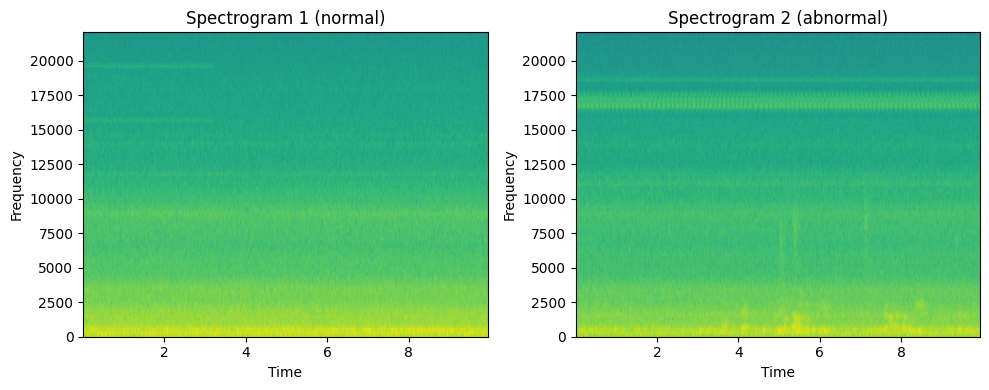

In [14]:
plot_spectogram("examples-to-show\sda_normal.wav", "examples-to-show\sda_abnormal.wav")

Once again the difference between a normal and an abnormal sample are visible "by eye", suggesting that the model should be able to detect the anomalies. The normal sample is similar to the normal of of the Edge Impulse dataset, a simple shade from a lighter part on the bottom, to a darker part on the top. The abnormal one, instead, has another little shade at arounf 17500 Hz of frequency.

In [2]:
anomaly_detection(preprocess_method='spectrogram', model_name='hst', transfer_learning='dense',
                  train_directory='mini-train', test_directory='test')

100%|██████████| 2164/2164 [25:05<00:00,  1.44it/s]


TRAINING: hst rocauc score using dense: 0.006392811296534018


100%|██████████| 176/176 [03:07<00:00,  1.06s/it]

TESTING: hst rocauc score using dense: 0.6597966193925789


In [3]:
anomaly_detection(preprocess_method='spectrogram', model_name='ae', transfer_learning='dense',
                  train_directory='mini-train', test_directory='test')

100%|██████████| 176/176 [08:02<00:00,  2.74s/it]

TESTING: ae rocauc score using dense: 0.5637607923827967


In [3]:
anomaly_detection(preprocess_method='spectrogram', model_name='rae', transfer_learning='dense',
                  train_directory='mini-train', test_directory='test')

100%|██████████| 176/176 [06:22<00:00,  2.17s/it]

TESTING: rae rocauc score using dense: 0.5638633368299308


In [3]:
anomaly_detection(preprocess_method='spectrogram', model_name='wae', transfer_learning='dense',
                  train_directory='mini-train', test_directory='test')

100%|██████████| 176/176 [07:36<00:00,  2.59s/it]

TESTING: wae rocauc score using dense: 0.556675139191479


**Compact Results:**

    hst: 0.6597966193925789

    ae: 0.5637607923827967

    rae: 0.5638633368299308
    
    wae: 0.556675139191479

The results are bad, but it could be due to a low amount (5000) of samples studied among the whole dataset (over 20000). Training the model on the full dataset could improve the performance.

### Loading one of the best models (Weighted AutoEncoder) trained the full dataset

In [2]:
model = torch.load('wae.pth')

In [3]:
model = train_model(preprocess_method='spectrogram', model=model, num_params=1, transfer_learning='dense',
                  train_directory='mini-train')

100%|██████████| 2164/2164 [26:02<00:00,  1.38it/s]

TRAINING: rocauc score using dense: 0.7749935815147626


In [4]:
torch.save(model, 'wae.pth')

In [3]:
pathscores = test_model(preprocess_method='spectrogram', model=model, num_params=1, transfer_learning='dense',
                  test_directory='test')

100%|██████████| 176/176 [01:34<00:00,  1.86it/s]

TESTING: rocauc score using dense: 0.4868380777471687


In [4]:
pathscores[:10]

[('test\\01_02_2023-14_00_01_normal.wav', 0.002188251819461584),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.0024185560178011656),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.002077308250591159),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.0025192596949636936),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.0035031582228839397),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.0023147501051425934),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.003424091264605522),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.0018199842888861895),
 ('test\\01_02_2023-14_00_01_normal.wav', 0.019618405029177666),
 ('test\\01_02_2023-14_00_11_normal.wav', 0.001940189627930522)]

In [7]:
normal_count = 0
abnormal_count = 0

for path, score in pathscores:
    if "normal" in path and normal_count < 10:
        print(f"{path}: {score}")
        normal_count += 1
    elif "abnormal" in path and abnormal_count < 10:
        print(f"{path}: {score}")
        abnormal_count += 1

    if normal_count == 10 and abnormal_count == 10:
        break

test\01_02_2023-14_00_01_normal.wav: 0.002188251819461584
test\01_02_2023-14_00_01_normal.wav: 0.0024185560178011656
test\01_02_2023-14_00_01_normal.wav: 0.002077308250591159
test\01_02_2023-14_00_01_normal.wav: 0.0025192596949636936
test\01_02_2023-14_00_01_normal.wav: 0.0035031582228839397
test\01_02_2023-14_00_01_normal.wav: 0.0023147501051425934
test\01_02_2023-14_00_01_normal.wav: 0.003424091264605522
test\01_02_2023-14_00_01_normal.wav: 0.0018199842888861895
test\01_02_2023-14_00_01_normal.wav: 0.019618405029177666
test\01_02_2023-14_00_11_normal.wav: 0.001940189627930522
test\01_02_2023-14_11_40_abnormal.wav: 0.002146757673472166
test\01_02_2023-14_11_40_abnormal.wav: 0.0020105501171201468
test\01_02_2023-14_11_40_abnormal.wav: 0.001970055978745222
test\01_02_2023-14_11_40_abnormal.wav: 0.002005722839385271
test\01_02_2023-14_11_40_abnormal.wav: 0.0020084851421415806
test\01_02_2023-14_11_40_abnormal.wav: 0.001994855236262083
test\01_02_2023-14_11_40_abnormal.wav: 0.002160899806

It's notable that the model predicts a very low number for all the samples, both normal and abnormal ones, not being able to distinguish among them. This could be because the anomalies are not as evident as we could expect from the spectogram plot

## Comparison of the results on different datasets

**CreditCard dataset:**

    hst: 0.7861383496764726

    ae: 0.83436728703889

    wae: 0.9593756253752251

    rae: 0.9050096724701487

    kitnet: 0.9732506170368889

    rrcf: 0.8313321326129011
    

**Edge Impulse dataset:**

    hst: 0.9626771833561958

    ae: 0.8356267146776407

    wae: 0.8144933127572016

    rae: 0.8355838477366254

    kitnet: 0.9926983310470965

    rrcf: 0.9168167009602194


**Project's dataset:**

    hst: 0.6597966193925789

    ae: 0.5637607923827967

    rae: 0.5638633368299308
    
    wae: 0.556675139191479

## Testing with completely different sound

To understand if the problem is due to the slight difference between a normal and an abnormal sample, it's possible to check the prediction on a sample which is completely different from those of the heat pump (for example a whistle of very high frequency).

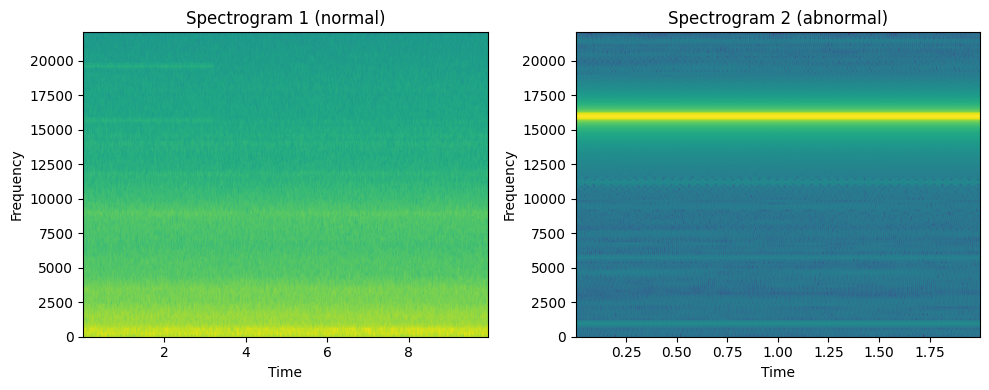

In [10]:
plot_spectogram("examples-to-show\sda_normal.wav", "examples-to-show/16000Hz.wav")

In [6]:
test_sample(preprocess_method='spectrogram', model=model, num_params=1, transfer_learning='dense',
                  test_directory='examples-to-show\external_sounds')

100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


[('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706),
 ('examples-to-show\\external_sounds\\16000hz_bxbi3JJz.wav',
  0.15623386204242706)]

Now the score is a bit higher than the previous cases, but still closer to zero rather than one. 
This suggests two things that could be problematic: 
- the training set teached the model to basically predict every sample as normal
- the score of the prediction is not a simple number to interpret as "if it's nearer to 0, than the prediction is normal, instead, if it's nearer to 1, the prediction is abnormal"

## Conclusions

The methods show impressive performance on well-known, stable and numerical dataset like the one in CreditCard: this means that the anomaly detection models work overall correctly in this context (although svm and ilof should be improved). Moreover, using the pipeline to extract meaningful information from a .wav file great performance are achieved when applied on Edge Impulse dataset, while results are poor on the project's one.
This could be for multiple reasons:
- very unbalanced datasets like the one of the project (where anomalies were 40 samples among 20.000) could teach the model to simply predict normal for all the samples
- the neural network used for feature extraction is not good for all the sound anomaly detection but only for the one it was trained on (Edge Impulse), because it looks for different attributes based on what the anomalies of the original dataset looked like.

C:\Users\loren\AppData\Local\Temp\ipykernel_43356\1058484754.py:5: WavFileWarning: Reached EOF prematurely; finished at 320044 bytes, expected 320052 bytes from header.
  Fs2, aud2 = wavfile.read(wav_path2)


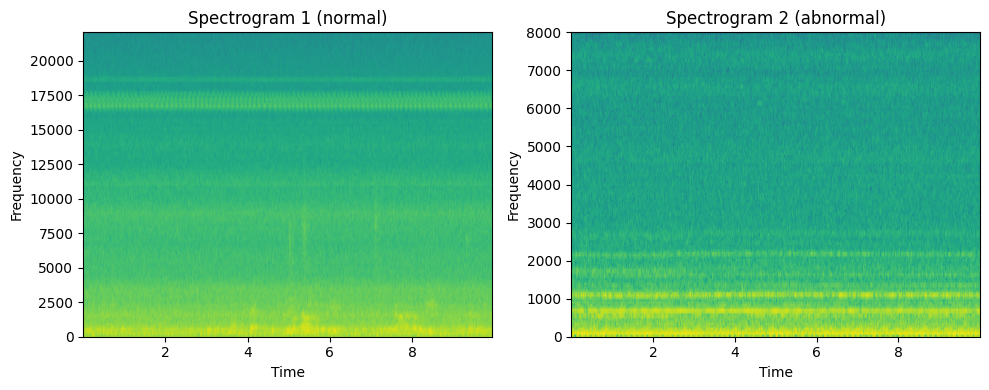

In [4]:
plot_spectogram("examples-to-show\sda_abnormal.wav", "examples-to-show\edgeimpulse_abnormal.wav")

In [2]:
anomaly_detection(preprocess_method='spectrogram', model_name='wae', transfer_learning=None,
                  train_directory='micro-train', test_directory='test')

  0%|          | 0/628 [00:00<?, ?it/s]

100%|██████████| 628/628 [04:45<00:00,  2.20it/s]


TRAINING: wae rocauc: 0.9998230401698814


100%|██████████| 176/176 [00:55<00:00,  3.15it/s]

TESTING: wae rocauc: 0.05293464952555862
